<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclustering/applications/clustering/20newsgroup/Topic%20Identification%20in%20News%20using%20SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [50]:
import re
import spacy
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import scipy
from scipy import linalg

import gensim
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

nlp = spacy.load('en', disable=['parser', 'ner'])

### 20 Newsgroup Dataset

In [4]:
dataset = fetch_20newsgroups(shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

documents = dataset.data
len(documents)

11314

In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

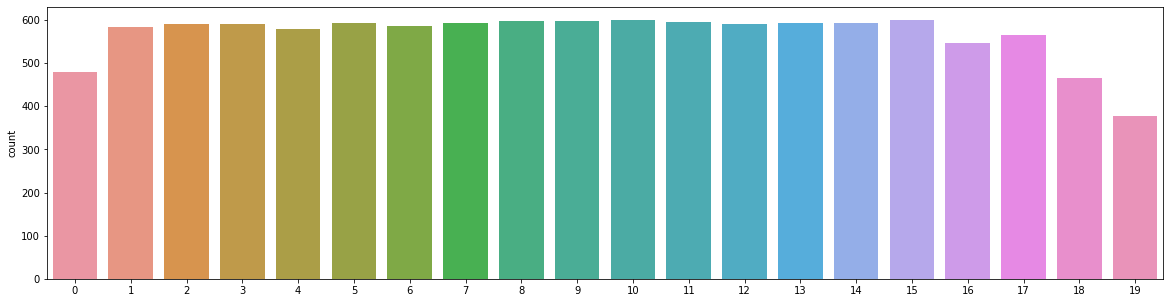

In [11]:
plt.figure(figsize=(20, 5))
sns.countplot(dataset.target)

### Tokenization

In [15]:
def sentence_to_tokens(sent):
    # remove emails
    sent = re.sub(r'\S*@\S*\s?', '', sent)
    # remove newline chars
    sent = re.sub(r'\s+', ' ', sent)
    # remove single quotes
    sent = re.sub(r"\'", "", sent)
    # converts to lower case tokens and removes tokens that are
    # too small & too long. Also remove accent characters & punct
    tokens = simple_preprocess(str(sent), deacc=True)
    return tokens

In [18]:
%%time
tokenized_data = [sentence_to_tokens(doc) for doc in documents]

CPU times: user 6.14 s, sys: 133 ms, total: 6.27 s
Wall time: 6.28 s


In [19]:
" ".join(tokenized_data[0])

'was wondering if anyone out there could enlighten me on this car saw the other day it was door sports car looked to be from the late early it was called bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all know if anyone can tellme model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please mail'

### Pre-processing

In [20]:
%%time
# create bigrams from the tokenized data
bigram = gensim.models.Phrases(tokenized_data, threshold=50)
# make a bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)

CPU times: user 11 s, sys: 86.3 ms, total: 11.1 s
Wall time: 11.1 s


In [21]:
def process_words(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # remove stopwords
    stop_free = [[word for word in doc if word not in stop_words] for doc in texts]
    # bigrams
    bigram_data = [bigram_mod[doc] for doc in stop_free]

    texts_out = []
    for sent in bigram_data:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    # join words into sentence in-order to make it useful to tfidf processing
    texts_out = [" ".join(words) for words in texts_out]
    return texts_out


In [22]:
%%time
processed_data = process_words(tokenized_data)

CPU times: user 1min 34s, sys: 924 ms, total: 1min 35s
Wall time: 1min 35s


In [23]:
processed_data[0]

'wonder could enlighten car see day door look late early call bricklin door really small addition separate rest body know tellme model name engine year production car make history info funky look car mail'

### Tfidf

In [25]:
tfidf = TfidfVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')

data_vectorized = tfidf.fit_transform(processed_data)

In [26]:
# document-term matrix
data_vectorized.shape

(11314, 5369)

### SVD - Scipy

In [56]:
%%time
U, s, Vh = scipy.sparse.linalg.svds(data_vectorized, k=20)

CPU times: user 422 ms, sys: 226 ms, total: 649 ms
Wall time: 342 ms


In [57]:
U.shape

(11314, 20)

In [60]:
s

array([ 4.92891419,  4.96339719,  4.99226158,  5.04066519,  5.10180911,
        5.2099983 ,  5.28255264,  5.39213767,  5.39934617,  5.44676326,
        5.56493994,  5.72199803,  5.79020032,  5.95870598,  6.25719729,
        6.57743219,  6.66125011,  6.96593609,  8.31975216, 14.27542397])

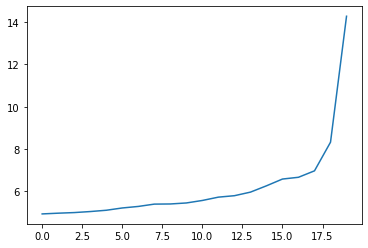

In [61]:
plt.plot(s)

In [59]:
Vh.shape

(20, 5369)

In [63]:
vocab = np.array(tfidf.get_feature_names())

In [64]:
# top key words in each topic
terms = tfidf.get_feature_names()

for i, comp in enumerate(Vh):
    terms_dis = zip(terms, comp)
    sorted_terms = sorted(terms_dis, key=lambda x:x[1], reverse=True)
    top_key_words = sorted_terms[:10]
    t = " ".join(w[0] for w in top_key_words)
    print(f"Topic {i}: {t}")

Topic 0: car card question program thank run answer need monitor time
Topic 1: driver make version believe problem offer car sale work include
Topic 2: program driver work think version need say run available software
Topic 3: soon surrender chastity shameful intellect driver need want think say
Topic 4: problem know mail sell game think sale window people price
Topic 5: post driver car question list address mail read article group
Topic 6: problem file work thank try card monitor fix time help
Topic 7: think say look good bit buy thing monitor program really
Topic 8: think thank driver people file card make chip window key
Topic 9: know think file card people want good let look monitor
Topic 10: file say card driver know car sell look price buy
Topic 11: car know key window bike think look chip driver ride
Topic 12: car window sell price look sale include card buy good
Topic 13: card driver know chip key window bit say video mode
Topic 14: key chip clipper bit encryption phone governm

### SVD - Scikit-learn

In [39]:
%%time
svd = TruncatedSVD(
    n_components=20,
    algorithm="randomized",
    n_iter=1000,
    random_state=42
)

svd.fit(data_vectorized)

CPU times: user 59.9 s, sys: 44.2 s, total: 1min 44s
Wall time: 52.8 s


In [40]:
# topic-term matrix
svd.components_

array([[ 0.00255323,  0.00132199,  0.0015639 , ...,  0.00484884,
         0.00404874,  0.00159009],
       [-0.00378172,  0.00022909, -0.0020109 , ...,  0.00785711,
        -0.00310692,  0.00196894],
       [-0.0023384 ,  0.00073939, -0.0018754 , ..., -0.0003781 ,
         0.00450433, -0.00043351],
       ...,
       [-0.000517  ,  0.00109829, -0.00086703, ...,  0.00563794,
        -0.00077637,  0.00018139],
       [-0.00121836,  0.00060692, -0.00030447, ..., -0.00184145,
        -0.00617032, -0.00128298],
       [ 0.00090353,  0.00055378, -0.00069902, ...,  0.00375503,
         0.00023449,  0.00013991]])

In [41]:
svd.components_.shape

(20, 5369)

In [42]:
# top key words in each topic
terms = tfidf.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_dis = zip(terms, comp)
    sorted_terms = sorted(terms_dis, key=lambda x:x[1], reverse=True)
    top_key_words = sorted_terms[:10]
    t = " ".join(w[0] for w in top_key_words)
    print(f"Topic {i}: {t}")

Topic 0: know say think people make good time thank work want
Topic 1: thank window file card program driver mail drive problem run
Topic 2: game team player play year win good season score run
Topic 3: file window program run team game win problem player application
Topic 4: thank know mail post advance file say address game send
Topic 5: key chip clipper bit encryption phone government information send public
Topic 6: card driver know chip key window bit say video mode
Topic 7: drive key know say file chip scsi thank disk game
Topic 8: car know key window bike think look chip driver ride
Topic 9: file say card driver know car sell look price buy
Topic 10: say window car thank key run game chip problem memory
Topic 11: think thank driver people file card make chip window key
Topic 12: think say look good bit buy thing monitor program really
Topic 13: problem file work thank try card monitor fix time help
Topic 14: post driver car question list address mail read article group
Topic 15: